#Import thư viện

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#ACB

Đọc và tiền xử lý dữ liệu

In [2]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/ACB Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
1506,22800.0,22700.0,22800.0,22650.0,6390000,0.0022
1507,23050.0,22800.0,23100.0,22800.0,11470000,0.0110
1508,23200.0,23050.0,23250.0,23050.0,8860000,0.0065
1509,23250.0,23200.0,23250.0,23050.0,7080000,0.0022


Phân chia dữ liệu

In [3]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [4]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [6]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.0821692 , 0.10019031, 0.07939565, ..., 0.14593298, 0.14870653,
         0.13622788],
        [0.10019031, 0.07939565, 0.0780112 , ..., 0.14870653, 0.13622788,
         0.13484343],
        [0.07939565, 0.0780112 , 0.0960323 , ..., 0.13622788, 0.13484343,
         0.13206988],
        ...,
        [0.7356102 , 0.74255564, 0.74487079, ..., 0.622168  , 0.59438623,
         0.56660447],
        [0.74255564, 0.74487079, 0.75181623, ..., 0.59438623, 0.56660447,
         0.55734388],
        [0.74487079, 0.75181623, 0.74255564, ..., 0.56660447, 0.55734388,
         0.52030152]]),
 array([0.13484343, 0.13206988, 0.13484343, ..., 0.55734388, 0.52030152,
        0.45779255]))

In [7]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [8]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[20892.8 ],
       [20501.16],
       [21094.4 ],
       [21301.12],
       [21325.44],
       [22001.28],
       [22114.56],
       [22066.56],
       [22249.28],
       [23477.84],
       [23515.32],
       [22189.44],
       [22235.48],
       [22434.52],
       [23147.04],
       [22318.24],
       [23265.32],
       [23054.12],
       [23288.96],
       [23204.68],
       [22901.08],
       [22652.12],
       [22861.88],
       [22906.88],
       [22920.44],
       [22356.6 ],
       [22327.96],
       [22191.2 ],
       [22210.08],
       [22140.16],
       [22528.72],
       [22422.4 ],
       [22918.08],
       [23108.92],
       [23186.92],
       [23514.  ],
       [24308.8 ],
       [24711.84],
       [24162.32],
       [25011.08],
       [25077.84],
       [25426.68],
       [25799.  ],
       [26453.28],
       [25580.6 ],
       [26018.64],
       [24936.28],
       [25125.8 ],
       [24882.36],
       [25097.4 ],
       [24712.52],
       [24845.2 ],
       [2488

Dự báo 30 ngày kế

In [9]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)



[[29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]
 [29446.4]]


Vẽ đồ thị

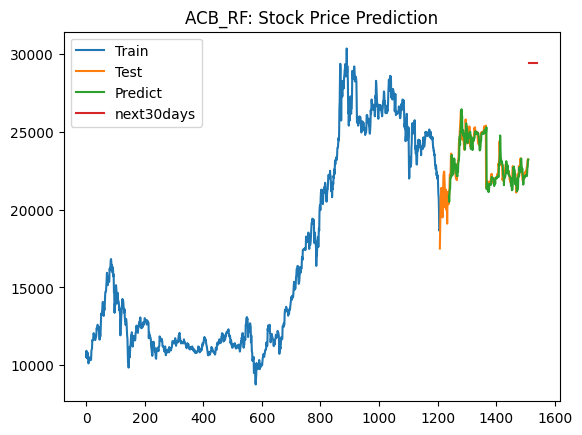

In [10]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 440.76649246111117
MAPE trên tập test là: 1.2454252668071923 %
MDA trên tập test là: 44.28044280442804 %


#PVS

Đọc và tiền xử lý dữ liệu

In [12]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/PVS Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,17292.0,16746.0,17474.0,16655.0,12030000,0.0440
1,17838.0,17383.0,17838.0,17383.0,6600000,0.0316
2,17292.0,18020.0,18020.0,17292.0,6460000,-0.0306
3,17565.0,17201.0,17656.0,16837.0,8730000,0.0158
4,17110.0,17383.0,17474.0,17019.0,6100000,-0.0259
...,...,...,...,...,...,...
1511,37400.0,37500.0,38000.0,37400.0,1840000,-0.0027
1512,37900.0,37600.0,37900.0,37100.0,2540000,0.0134
1513,38400.0,37900.0,38600.0,37900.0,3040000,0.0132
1514,38200.0,37400.0,38700.0,37400.0,1440000,-0.0052


Phân chia dữ liệu

In [13]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [14]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [15]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.26157729, 0.27880126, 0.26157729, ..., 0.54293375, 0.52570978,
         0.49987382],
        [0.27880126, 0.26157729, 0.27018927, ..., 0.52570978, 0.49987382,
         0.52570978],
        [0.26157729, 0.27018927, 0.25583596, ..., 0.49987382, 0.52570978,
         0.51709779],
        ...,
        [0.53719243, 0.53107256, 0.56466877, ..., 0.42586751, 0.44794953,
         0.39116719],
        [0.53107256, 0.56466877, 0.56769716, ..., 0.44794953, 0.39116719,
         0.40694006],
        [0.56466877, 0.56769716, 0.55548896, ..., 0.39116719, 0.40694006,
         0.44164038]]),
 array([0.52570978, 0.51709779, 0.50561514, ..., 0.40694006, 0.44164038,
        0.41640379]))

In [17]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [18]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[18436.54],
       [19373.48],
       [19286.28],
       [18694.  ],
       [18709.56],
       [19483.26],
       [19575.34],
       [21302.86],
       [21234.68],
       [20548.82],
       [22815.78],
       [22938.96],
       [23048.16],
       [23421.04],
       [23494.72],
       [23180.6 ],
       [22357.48],
       [22849.5 ],
       [23080.98],
       [23038.24],
       [23268.12],
       [23046.38],
       [23146.6 ],
       [22171.96],
       [22984.22],
       [22420.84],
       [21101.02],
       [21938.56],
       [21906.96],
       [21184.48],
       [21143.52],
       [22605.02],
       [22684.56],
       [23139.72],
       [23129.96],
       [23106.18],
       [23022.06],
       [23046.98],
       [23769.32],
       [23126.08],
       [23319.46],
       [24028.16],
       [25109.62],
       [24926.24],
       [24900.64],
       [24624.22],
       [25512.18],
       [24092.56],
       [23931.26],
       [23684.72],
       [23236.74],
       [23023.1 ],
       [2363

Dự báo 30 ngày kế

In [19]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[34963.76]
 [34330.94]
 [33133.04]
 [32848.56]
 [32804.04]
 [32804.04]
 [32815.66]
 [32560.22]
 [32198.3 ]
 [30729.4 ]
 [29991.9 ]
 [29589.28]
 [29447.98]
 [29002.98]
 [28333.46]
 [28260.  ]
 [28159.4 ]
 [28105.22]
 [28254.2 ]
 [28271.66]
 [28451.64]
 [28296.84]
 [28343.28]
 [28308.44]
 [28407.12]
 [28381.98]
 [28385.86]
 [28629.68]
 [28469.08]
 [28567.78]]


Vẽ đồ thị

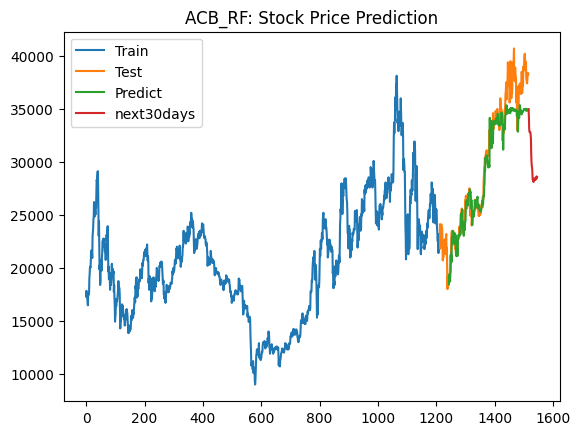

In [20]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 1771.3938493057467
MAPE trên tập test là: 3.6213330494832476 %
MDA trên tập test là: 48.529411764705884 %


#VNM

Đọc và tiền xử lý dữ liệu

In [22]:
# Chuẩn bị dữ liệu

path ="/content/drive/MyDrive/Colab Notebooks/Data Analysis in Business 1/DATASET/VNM Historical Data.csv"
data = pd.read_csv(path, index_col='Date', parse_dates=True)

# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data = data.reset_index(drop=True)

data

,Price,Open,High,Low,Vol.,Change %
0,159039.0,151736.0,159039.0,151736.0,1500000,0.0498
1,164719.0,159039.0,166423.0,159039.0,1700000,0.0357
2,161473.0,164719.0,166342.0,160662.0,852080,-0.0197
3,158227.0,158227.0,159850.0,151898.0,1140000,-0.0201
4,150924.0,158227.0,160580.0,150924.0,1430000,-0.0462
...,...,...,...,...,...,...
1509,67000.0,68100.0,68200.0,67000.0,3510000,-0.0162
1510,67000.0,67100.0,67400.0,66300.0,3060000,0.0000
1511,68100.0,67000.0,68200.0,67000.0,2600000,0.0164
1512,67800.0,67900.0,68300.0,67800.0,2590000,-0.0044


Phân chia dữ liệu

In [23]:
# Scaler data
price = data['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Chia dữ liệu thành train test validate
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
#val_size = len(price_scaled) - train_size - test_size

train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
#val_data = price_scaled[train_size+test_size:]

Xây dựng thuật toán

In [24]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [25]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [26]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1])
X_train, y_train

(array([[0.85532449, 0.9050105 , 0.876616  , ..., 0.97283015, 0.96568341,
         0.96496612],
        [0.9050105 , 0.876616  , 0.84822149, ..., 0.96568341, 0.96496612,
         0.95495893],
        [0.876616  , 0.84822149, 0.78433824, ..., 0.96496612, 0.95495893,
         0.95352434],
        ...,
        [0.09749392, 0.11554096, 0.13186911, ..., 0.08546256, 0.0742902 ,
         0.07343119],
        [0.11554096, 0.13186911, 0.133588  , ..., 0.0742902 , 0.07343119,
         0.07944688],
        [0.13186911, 0.133588  , 0.12499442, ..., 0.07343119, 0.07944688,
         0.06569662]]),
 array([0.95495893, 0.95352434, 0.90204509, ..., 0.07944688, 0.06569662,
        0.06397773]))

In [27]:
model = RandomForestRegressor(n_estimators=50)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50)

In [28]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test = scaler.inverse_transform([y_test])
test_predict

array([[75331.31 ],
       [78027.746],
       [77912.244],
       [80008.524],
       [80708.712],
       [80308.85 ],
       [80922.662],
       [80473.626],
       [80305.232],
       [82372.024],
       [83498.384],
       [80238.78 ],
       [80419.47 ],
       [80278.63 ],
       [79363.63 ],
       [75983.748],
       [76018.214],
       [76119.692],
       [76122.386],
       [75971.842],
       [76116.66 ],
       [77500.856],
       [78595.498],
       [75245.076],
       [75278.466],
       [75229.462],
       [75887.46 ],
       [76307.2  ],
       [76364.03 ],
       [76093.238],
       [78700.022],
       [78783.838],
       [80721.418],
       [80025.464],
       [80655.854],
       [80786.14 ],
       [79437.798],
       [80025.39 ],
       [80345.608],
       [79452.654],
       [80090.78 ],
       [80441.392],
       [80086.102],
       [80097.744],
       [79587.11 ],
       [76084.752],
       [75953.184],
       [75656.972],
       [76007.17 ],
       [78035.622],


Dự báo 30 ngày kế

In [29]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = data['Price'].values[-30:]
next_30_days = []

for i in range(30):
    x = last_30_days[-time_step:].reshape(1, time_step)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)


[[166717.56]
 [165668.02]
 [164664.24]
 [164302.96]
 [163158.58]
 [159627.38]
 [158711.88]
 [158728.28]
 [158492.9 ]
 [158183.9 ]
 [157783.4 ]
 [157886.42]
 [157526.78]
 [157356.74]
 [157989.4 ]
 [158445.48]
 [158594.24]
 [158834.52]
 [159926.52]
 [160405.5 ]
 [160962.98]
 [161049.64]
 [161245.8 ]
 [161450.16]
 [162215.2 ]
 [163993.82]
 [165800.28]
 [168362.16]
 [172145.12]
 [172718.96]]


Vẽ đồ thị

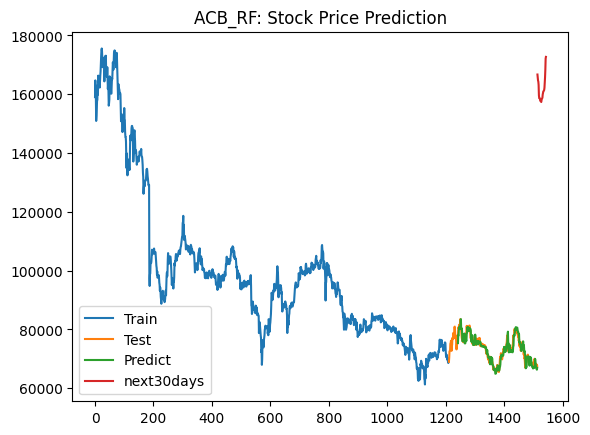

In [30]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
from matplotlib import pyplot as plt

# train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label="Train")
# plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_data_index = pd.RangeIndex(start=len(data) - len(test_data), stop=len(data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label="Test")

test_data_index = pd.RangeIndex(start=train_size+31, stop=len(data), step=1)
plt.plot(test_data_index, test_predict.squeeze(), label="Predict", linestyle="-")

#30 days
predict_data_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
plt.plot(predict_data_index, next_30_days.squeeze(), label="next30days")


# # Dự đoán 30 điểm tiếp theo
plt.legend()
plt.title('ACB_RF: Stock Price Prediction')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(y_test[0], test_predict[:, 0])


print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')


RMSE trên tập test là: 1138.234196507351
MAPE trên tập test là: 1.233524389090278 %
MDA trên tập test là: 43.17343173431734 %
